In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras as K
from keras.layers import *
import matplotlib.pyplot as plt
import numpy as np


tf.keras.backend.set_floatx("float64")

In [81]:
def import_data():

    ds,info = tfds.load('caltech_birds2010', split='all',with_info=True)
    ds_train = ds.skip(300)
    ds_test = ds.take(300)
    return ds_train,ds_test,info

In [83]:
ds_train_raw,ds_test_raw,info = import_data()

In [84]:
IMAGE_SIZE = 128
def pre_process_image(record):
    
    image = record["image"]
    image = image / 255
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32)
    
    seg_image = record["segmentation_mask"]
    seg_image = tf.image.resize(seg_image, (IMAGE_SIZE, IMAGE_SIZE))

    seg_image = tf.cast(seg_image, tf.uint8)
    seg_image = seg_image % 2
    seg_image = tf.cast(seg_image, tf.float32)
    return image,seg_image

resize_train = ds_train_raw.map(pre_process_image)
resize_test = ds_test_raw.map(pre_process_image)

In [85]:

def dice_coef(y_true, y_pred):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f))

def diceCoefLoss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

In [86]:
input_img = Input(next(iter(resize_train))[0].shape, name="input_img") 
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same',name="decoded")(x)
    
autoencoder = K.Model(input_img, decoded)
optimizer = K.optimizers.rmsprop_v2.RMSprop(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss=diceCoefLoss,metrics=[K.metrics.MeanIoU(num_classes=2),dice_coef])

In [87]:
callbacks = [
    K.callbacks.ModelCheckpoint("bird_autoencoder.h5", save_best_only=True, monitor="val_dice_coef",mode="max")
]

# Train the model, doing validation at the end of each epoch.
epochs = 60


In [88]:
ds_train = resize_train.batch(64).prefetch(tf.data.AUTOTUNE)
ds_test = resize_test.batch(64).prefetch(tf.data.AUTOTUNE)

In [89]:
history = autoencoder.fit(ds_train,validation_data=ds_test,epochs=epochs,verbose=2,callbacks=callbacks)

Epoch 1/60
90/90 - 153s - loss: 0.6608 - mean_io_u_1: 0.4193 - dice_coef: 0.3392 - val_loss: 0.6310 - val_mean_io_u_1: 0.4197 - val_dice_coef: 0.3695 - 153s/epoch - 2s/step
Epoch 2/60
90/90 - 162s - loss: 0.4851 - mean_io_u_1: 0.5505 - dice_coef: 0.5150 - val_loss: 0.4375 - val_mean_io_u_1: 0.5850 - val_dice_coef: 0.5646 - 162s/epoch - 2s/step
Epoch 3/60
90/90 - 149s - loss: 0.4289 - mean_io_u_1: 0.5972 - dice_coef: 0.5710 - val_loss: 0.4035 - val_mean_io_u_1: 0.5985 - val_dice_coef: 0.5994 - 149s/epoch - 2s/step
Epoch 4/60
90/90 - 145s - loss: 0.4012 - mean_io_u_1: 0.5985 - dice_coef: 0.5987 - val_loss: 0.3876 - val_mean_io_u_1: 0.5862 - val_dice_coef: 0.6149 - 145s/epoch - 2s/step
Epoch 5/60
90/90 - 146s - loss: 0.3823 - mean_io_u_1: 0.5759 - dice_coef: 0.6176 - val_loss: 0.3754 - val_mean_io_u_1: 0.5271 - val_dice_coef: 0.6268 - 146s/epoch - 2s/step
Epoch 6/60
90/90 - 146s - loss: 0.3701 - mean_io_u_1: 0.5335 - dice_coef: 0.6298 - val_loss: 0.3684 - val_mean_io_u_1: 0.4796 - val_dic

Epoch 49/60
90/90 - 145s - loss: 0.2145 - mean_io_u_1: 0.4319 - dice_coef: 0.7855 - val_loss: 0.2798 - val_mean_io_u_1: 0.4324 - val_dice_coef: 0.7210 - 145s/epoch - 2s/step
Epoch 50/60
90/90 - 145s - loss: 0.2121 - mean_io_u_1: 0.4313 - dice_coef: 0.7881 - val_loss: 0.2834 - val_mean_io_u_1: 0.4288 - val_dice_coef: 0.7174 - 145s/epoch - 2s/step
Epoch 51/60
90/90 - 145s - loss: 0.2089 - mean_io_u_1: 0.4323 - dice_coef: 0.7911 - val_loss: 0.3129 - val_mean_io_u_1: 0.4232 - val_dice_coef: 0.6875 - 145s/epoch - 2s/step
Epoch 52/60
90/90 - 146s - loss: 0.2060 - mean_io_u_1: 0.4332 - dice_coef: 0.7941 - val_loss: 0.2850 - val_mean_io_u_1: 0.4319 - val_dice_coef: 0.7156 - 146s/epoch - 2s/step
Epoch 53/60
90/90 - 145s - loss: 0.2037 - mean_io_u_1: 0.4321 - dice_coef: 0.7964 - val_loss: 0.2785 - val_mean_io_u_1: 0.4297 - val_dice_coef: 0.7221 - 145s/epoch - 2s/step
Epoch 54/60
90/90 - 146s - loss: 0.2010 - mean_io_u_1: 0.4330 - dice_coef: 0.7990 - val_loss: 0.3115 - val_mean_io_u_1: 0.4237 - v

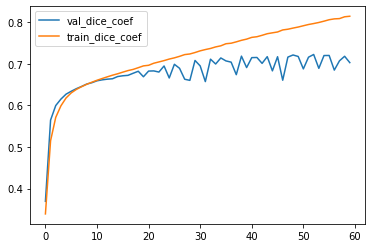

In [90]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_dice_coef"],label= "val_dice_coef")
plt.plot(history.history["dice_coef"],label="train_dice_coef")
plt.legend()

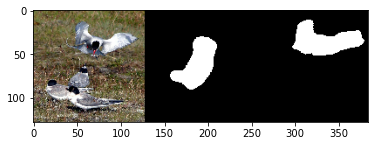

tf.Tensor(0.2778693, shape=(), dtype=float32)


In [92]:
image = next(iter(resize_test.shuffle(100).take(1)))

mask = np.repeat(image[1],3).reshape(IMAGE_SIZE,IMAGE_SIZE,3)
pred = np.round(np.repeat(autoencoder.predict(image[0].numpy().reshape(-1,128,128,3))[0],3).reshape((IMAGE_SIZE,IMAGE_SIZE,3)))
plt.imshow(np.hstack([image[0],pred,mask]))

# display that image
plt.show()
print(dice_coef(mask,tf.cast(pred,tf.float32)))

In [93]:
dice_coeff_vals = []
n = int(resize_test.cardinality())
for image in iter(resize_test):

    mask = image[1]
    pred = autoencoder.predict(tf.reshape(image[0],(-1,128,128,3)))
    dice_coeff_vals.append(dice_coef(mask,tf.cast(pred,tf.float32)))

dice_coeff_mean = sum(dice_coeff_vals)/n
dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5

In [94]:
float(dice_coeff_mean)

0.6572328209877014

In [95]:
float(dice_coeff_std)

0.21912740170955658